In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from tensorflow.keras.models import load_model
import cv2
import seaborn as sns

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
!git clone https://github.com/juliocardenas25/Magnetic_methods.git

Cloning into 'Magnetic_methods'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 73 (delta 20), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (73/73), done.


In [3]:
## Useful functions

from Magnetic_methods.Utils.Utils_colab import *

In [4]:
!unzip /content/Magnetic_methods/test_data/V12_YOLO_par_3_9600.hdf5.zip -d Magnetic_methods/test_data/

Archive:  /content/Magnetic_methods/test_data/V12_YOLO_par_3_9600.hdf5.zip
  inflating: Magnetic_methods/test_data/V12_YOLO_par_3_9600.hdf5  


In [5]:
hdf5_path = '/content/Magnetic_methods/test_data/V12_YOLO_par_3_9600.hdf5'

X_train, X_dev, X_test, Y_train, Y_dev, Y_test = load_dataset_train_dev_test(hdf5_path)


In [6]:
################ Confirming data retrieved shapes ###############

#Standardizing training data
#X_train_std = standardize_x_array(X_train)
#X_dev_std = standardize_x_array(X_dev)
#X_test_std = standardize_x_array(X_test)

##### to rgb
X_train = gray_to_rgb(X_train)
X_dev = gray_to_rgb(X_dev)
X_test = gray_to_rgb(X_test)

print("X_train shape : " + str(X_train.shape), "X_dev shape : " + str(X_train.shape), "X_test shape : " + str(X_train.shape)) 
print("Y_train shape : " + str(Y_train.shape), "Y_dev par shape : " + str(Y_dev.shape), "Y_test par shape : " + str(Y_test.shape)) 

X_train shape : (6720, 64, 64, 3) X_dev shape : (6720, 64, 64, 3) X_test shape : (6720, 64, 64, 3)
Y_train shape : (6720, 4) Y_dev par shape : (1920, 4) Y_test par shape : (960, 4)


In [7]:
from keras import backend as K

def r2(y_true, y_pred):

    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    
    return ( 1 - SS_res/(SS_tot + K.epsilon()))


In [11]:
load_path = "/content/Magnetic_methods/test_data/Densenet/Densenet_par_8_TL.hdf5"

best_model = load_model(load_path, custom_objects={'r2': r2})

best_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][0]']             
                                                                                       

In [12]:
i=0
for layer in best_model.layers:
  
 print(f"{i}: {layer.name}")
 i+=1

0: input_1
1: zero_padding2d
2: conv1/conv
3: conv1/bn
4: conv1/relu
5: zero_padding2d_1
6: pool1
7: conv2_block1_0_bn
8: conv2_block1_0_relu
9: conv2_block1_1_conv
10: conv2_block1_1_bn
11: conv2_block1_1_relu
12: conv2_block1_2_conv
13: conv2_block1_concat
14: conv2_block2_0_bn
15: conv2_block2_0_relu
16: conv2_block2_1_conv
17: conv2_block2_1_bn
18: conv2_block2_1_relu
19: conv2_block2_2_conv
20: conv2_block2_concat
21: conv2_block3_0_bn
22: conv2_block3_0_relu
23: conv2_block3_1_conv
24: conv2_block3_1_bn
25: conv2_block3_1_relu
26: conv2_block3_2_conv
27: conv2_block3_concat
28: conv2_block4_0_bn
29: conv2_block4_0_relu
30: conv2_block4_1_conv
31: conv2_block4_1_bn
32: conv2_block4_1_relu
33: conv2_block4_2_conv
34: conv2_block4_concat
35: conv2_block5_0_bn
36: conv2_block5_0_relu
37: conv2_block5_1_conv
38: conv2_block5_1_bn
39: conv2_block5_1_relu
40: conv2_block5_2_conv
41: conv2_block5_concat
42: conv2_block6_0_bn
43: conv2_block6_0_relu
44: conv2_block6_1_conv
45: conv2_block

In [13]:
layer_to_plot = 141
best_model.layers[layer_to_plot]

layer_outputs = K.function([best_model.layers[0].input], outputs=[best_model.layers[layer_to_plot].output])

In [14]:
layer_output_train = layer_outputs([X_train[:]])[0]
layer_output_dev = layer_outputs([X_dev[:]])[0]
layer_output_test = layer_outputs([X_test[:]])[0]

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', n_iter=3000)
P1_tsne = tsne.fit_transform(layer_output_train)
P2_tsne = tsne.fit_transform(layer_output_dev)
P3_tsne = tsne.fit_transform(layer_output_test)

In [16]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = P2_tsne[:,0]
ty = P2_tsne[:,1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [17]:
label = (Y_dev[:,-1]+1).astype(str).copy()

label[label == '1.0'] = "r: 0.1m, h: 1m"
label[label == '2.0'] = "r: 0.1m, h: 1.2m"
label[label == '3.0'] = "r: 0.1m, h: 1.4m"
label[label == '4.0'] = "r: 0.1m, h: 1.6m"
label[label == '5.0'] = "r: 0.12m, h: 1m"
label[label == '6.0'] = "r: 0.12m, h: 1.2m"
label[label == '7.0'] = "r: 0.12m, h: 1.4m"
label[label == '8.0'] = "r: 0.12m, h: 1.6m"
label[label == '9.0'] = "r: 0.14m, h: 1m"
label[label == '10.0'] = "r: 0.14m, h: 1.2m"
label[label == '11.0'] = "r: 0.14m, h: 1.4m"
label[label == '12.0'] = "r: 0.14m, h: 1.6m"
label[label == '13.0'] = "r: 0.16m, h: 1m"
label[label == '14.0'] = "r: 0.16m, h: 1.2m"
label[label == '15.0'] = "r: 0.16m, h: 1.4m"
label[label == '16.0'] = "r: 0.16m, h: 1.6m"

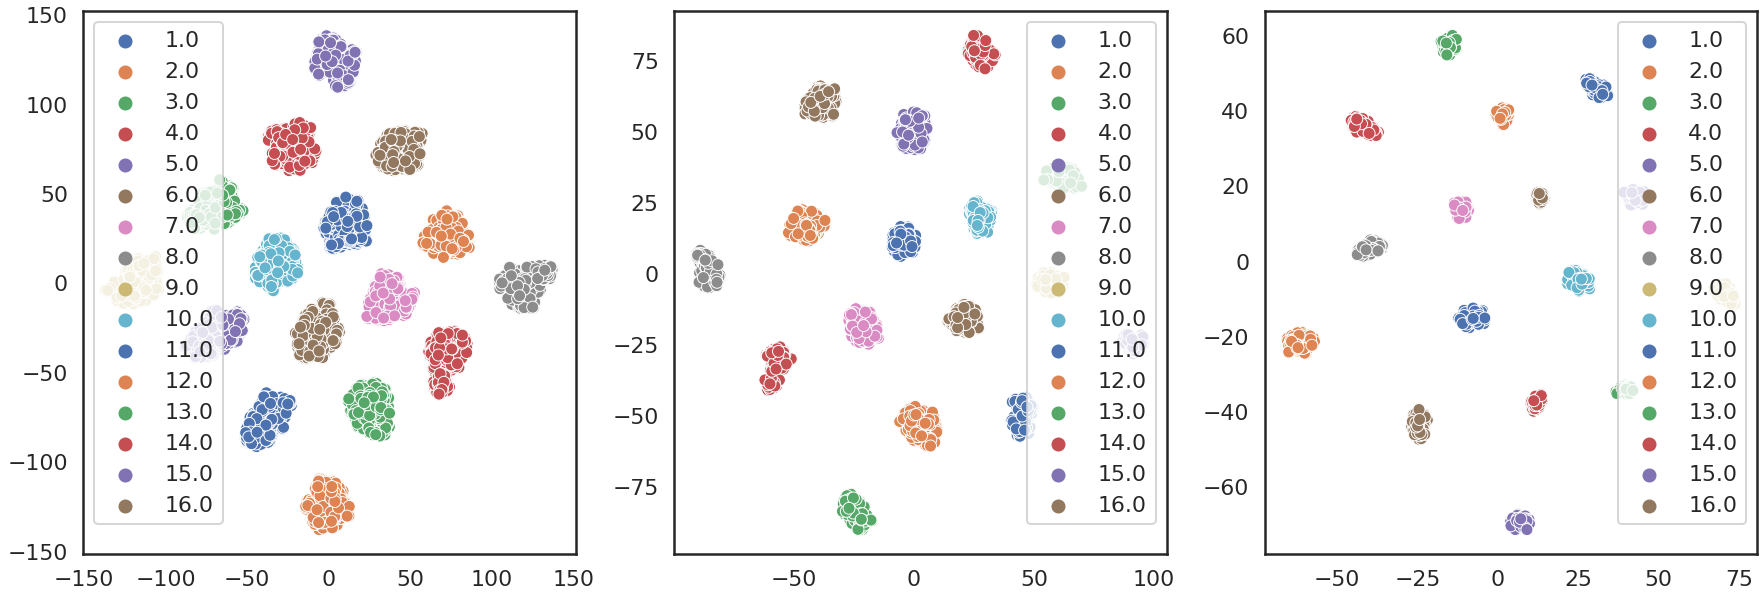

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(30,10))

sns.set_style("white")

#sns.set(font_scale=0.9)
#sns.set_context("poster", font_scale=1)

#fontsize = 25
#axs.tick_params(labelsize=20)
#axs[1].tick_params(labelsize=fontsize)
#axs[2].tick_params(labelsize=fontsize)

#plot_1 = axs[0].scatter(P1_tsne[:,0],P1_tsne[:,1], cmap='rainbow', c=Y_train[:,3], marker='.')
train = sns.scatterplot(x=P1_tsne[:,0],y=P1_tsne[:,1], hue=Y_train[:,-1]+1, ax=axs[0], palette="deep", cmap='rainbow')
#axs.set_title('Train')
#axs[0].legend(*plot_1.legend_elements(), title="Classes")

#plot_2 = axs[1].scatter(P2_tsne[:,0],P2_tsne[:,1], cmap='hsv', c=Y_dev[:,-1:], marker='x')
val = sns.scatterplot(x=P2_tsne[:,0],y=P2_tsne[:,1], hue=Y_dev[:,-1]+1, ax=axs[1], palette="deep", cmap='rainbow')
#axs.set_title('Validation')
#axs[1].legend(*plot_2.legend_elements(), title="Classes")

#plot_3 = axs[2].scatter(P3_tsne[:,0],P3_tsne[:,1], cmap='hsv', c=Y_test[:,-1:], marker='*')
test = sns.scatterplot(x=P3_tsne[:,0], y=P3_tsne[:,1], hue=Y_test[:,-1]+1, ax=axs[2], palette="deep", cmap='rainbow')
#axs.set_title('Validation set', fontsize=20)
#axs[2].legend(*plot_3.legend_elements(), title="Classes")

#test.legend(loc='best', bbox_to_anchor=(0.99, 0.5), ncol=8, fontsize=23)

#plt.legend([],[], frameon=False)

plt.savefig('tsne_val.pdf', dpi=200)